In [478]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os
import pickle

In [479]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [480]:
def loadNpy(filename):
    with open(filename, "rb") as f: return np.load(f)

db = f"{os.getcwd()}/../data2/slices/gaussian-grabber/size245000-newnorm-uf/"
#db = f"{os.getcwd()}/../data2/slices/tiled-gaussian-grabber/depthTile-size243000-newnorm-uf/"
data_type = ""

In [481]:
X_train, X_val, X_test = loadNpy(db + f"{data_type}X_train.npy"), loadNpy(db + f"{data_type}X_val.npy"), loadNpy(db + f"{data_type}X_test.npy")
y_train, y_val, y_test = loadNpy(db + f"{data_type}y_train.npy"), loadNpy(db + f"{data_type}y_val.npy"), loadNpy(db + f"{data_type}y_test.npy")

In [482]:
def npy_to_tensor(data, l=False):
    if not l:
        data = torch.from_numpy(data).float()
    else:
        data = torch.from_numpy(data).type(torch.LongTensor)
    return data

In [483]:
X_train, X_val, X_test = npy_to_tensor(X_train), npy_to_tensor(X_val), npy_to_tensor(X_test)
y_train, y_val, y_test = npy_to_tensor(y_train, 1), npy_to_tensor(y_val, 1), npy_to_tensor(y_test, 1)

In [147]:
X_train.shape

torch.Size([1176, 245009])

In [7]:
X_train = X_train[:,:-9]
X_val = X_val[:,:-9]
X_test = X_test[:,:-9]

In [148]:
X_trval = torch.cat((X_train, X_val), 0)
y_trval = torch.cat((y_train, y_val), 0)

trval_dataset = TensorDataset(X_trval, y_trval)

In [149]:
print(X_trval.shape)

torch.Size([1569, 245009])


In [150]:
dataset_len = X_trval.shape[0]
validation_split = 0.25
indices = list(range(dataset_len))

# Randomly splitting indices:
val_len = int(np.floor(validation_split * dataset_len))
validation_idx = np.random.choice(indices, size=val_len, replace=False)
train_idx = list(set(indices) - set(validation_idx))

# Contiguous split
# train_idx, validation_idx = indices[split:], indices[:split]

## Defining the samplers for each phase based on the random indices:
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

train_loader = torch.utils.data.DataLoader(trval_dataset, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(trval_dataset, sampler=validation_sampler)
data_loaders = {"train": train_loader, "val": validation_loader}
data_lengths = {"train": len(train_idx), "val": val_len}

In [28]:
X_train.shape[0] + X_val.shape[0]

1569

In [381]:
batch_size = 1

In [484]:
train_iterator = DataLoader(dataset=TensorDataset(X_train, y_train),batch_size=batch_size,shuffle=False)

val_iterator = DataLoader(dataset=TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

test_iterator = DataLoader(dataset=TensorDataset(X_test, y_test), batch_size=batch_size,shuffle=False)

In [10]:
X_train.shape

torch.Size([1176, 245000])

In [11]:
y_train

tensor([0, 0, 1,  ..., 1, 1, 1])

In [12]:
np.mean(y_train)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, dtype=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [10]:
np.mean(y_val)

TypeError: mean() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, dtype=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [83]:
np.mean(y_test)

0.45

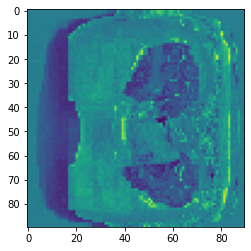

In [26]:
image = X_train[1000,:]
plt.imshow(image[:-9].reshape(90,90,60)[:,:,50])

In [107]:
for i in range(X_train.shape[0]):
    sample = X_train[i,:,:,:]
    print(sample)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3846, 0.5000, 0.3538,  ..., 0.1846, 0.2077, 0.4000],
         ...,
         [0.0000, 0.0000, 0.5000,  ..., 0.0000, 0.0000, 0.5000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.4135, 0.1579, 0.0451,  ..., 0.1955, 0.0075, 0.0226],
         [0.5536, 0.6071, 0.1339,  ..., 0.6071, 0.3304, 0.2321],
         ...,
         [0.1526, 0.4579, 0.7526,  ..., 0.4632, 0.4789, 0.5211],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.2500,  ..., 0.7500, 0.2500, 0.7500],
         [0.5092, 0.3926, 0.0491,  ..., 0.2393, 0.3804, 0.1043],
         [0.1364, 0.2898, 0.1420,  ..., 0.1023, 0.3580, 0.

tensor([[[0.4688, 0.3438, 0.3229,  ..., 0.3542, 0.0000, 0.4896],
         [0.1550, 0.4031, 0.3643,  ..., 0.0698, 0.1473, 0.1938],
         [0.4383, 0.2716, 0.3642,  ..., 0.1358, 0.0370, 0.2778],
         ...,
         [0.6758, 0.6593, 0.6209,  ..., 0.4615, 0.3077, 0.2363],
         [0.0476, 0.1095, 0.1286,  ..., 0.6429, 0.6143, 0.2381],
         [0.2913, 0.3386, 0.3150,  ..., 0.5512, 0.0945, 0.5512]],

        [[0.4196, 0.2411, 0.2143,  ..., 0.0893, 0.0268, 0.1429],
         [0.2477, 0.7064, 0.7798,  ..., 0.4495, 0.5596, 0.2018],
         [0.0063, 0.0188, 0.0188,  ..., 0.0625, 0.1813, 0.1562],
         ...,
         [0.3631, 0.2849, 0.3575,  ..., 0.4469, 0.4413, 0.4413],
         [0.9835, 0.8516, 0.5440,  ..., 0.2692, 0.5055, 0.5110],
         [0.3500, 0.1750, 0.1917,  ..., 0.4917, 0.0750, 0.2667]],

        [[0.0345, 0.0603, 0.1293,  ..., 0.1121, 0.3621, 0.0431],
         [0.2662, 0.4317, 0.4892,  ..., 0.1079, 0.3094, 0.1655],
         [0.0909, 0.1399, 0.3566,  ..., 0.0979, 0.1748, 0.

In [29]:
X_test.shape

(60, 343000)

In [12]:
input_size = 243540
h1_size = 800
h2_size = 800
h3_size = 600
h4_size = 400
h5_size = 100
num_classes = 2
num_epochs = 1000
batch_size = 8
learning_rate = 0.001

In [13]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, h1_size).to(device)
        #self.bn1 = nn.BatchNorm1d(h1_size)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(h1_size, h2_size).to(device)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(p=0.5)
        
        #self.drop1 = nn.Dropout(p=0.1)
        #self.bn2 = nn.BatchNorm1d(h2_size)
        self.fc3 = nn.Linear(h2_size, h3_size).to(device)
        #self.bn3 = nn.BatchNorm1d(h3_size)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(p=0.5)
        
        #self.bn3 = nn.BatchNorm1d(h3_size)
        self.fc4 = nn.Linear(h3_size, h4_size).to(device)
        #self.bn4 = nn.BatchNorm1d(h4_size)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(p=0.5)
        
        #self.bn4 = nn.BatchNorm1d(h4_size)
        #self.drop2 = nn.Dropout(p=0.1)
        self.fc5 = nn.Linear(h4_size, h5_size).to(device)
        #self.bn5 = nn.BatchNorm1d(h4_size)
        self.relu5 = nn.ReLU()
        self.drop5 = nn.Dropout(p=0.5)
        
        self.fc6 = nn.Linear(h5_size, num_classes).to(device)
    
    def forward(self, x):
        out = self.fc1(x)
        #out = self.bn1(out)
        out = self.relu1(out)
        out = self.drop1(out)
        
        out = self.fc2(out)
        #out = self.bn2(out)
        out = self.relu2(out)
        out = self.drop2(out)
        
        #out = self.bn2(out)
        out = self.fc3(out)
        #out = self.bn3(out)
        out = self.relu3(out)
        out = self.drop3(out)
        #out = self.bn3(out)
        
        out = self.fc4(out)
        #out = self.bn4(out)
        out = self.relu4(out)
        out = self.drop4(out)
        
        #out = self.bn4(out)
        out = self.fc5(out)
        #out = self.bn5(out)
        out = self.relu5(out)
        out = self.drop5(out)
        
        out = self.fc6(out)
        return out

In [11]:
def eval_nn(mod, data):
    preds = []
    actual = []
    
    shape = data.dataset.tensors[0].shape[1:]
    
    mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in data:
            images = images.reshape(-1,243540).to(device)
            labels = labels.to(device)
            outputs = mod(images)
            _, predicted = torch.max(outputs.data, 1)
            
            #y_pred_softmax = torch.log_softmax(outputs, dim = 1)
            #_, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
            #print(y_pred_tags.shape)
            #print(labels.shape)
            correct += (predicted == labels).sum().item()
    
            total += labels.size(0)
            #correct += (predicted == labels).sum().item()
            preds.append(y_pred_tags) #predicted)
            actual.append(labels)

        print(f'Accuracy of the network on the {total} test images: {100 * correct / total} %')
    return preds, actual, correct/total

In [12]:
nn_model = NeuralNet(input_size, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate, weight_decay=1e-3)

In [2]:
from libauc.losses import AUCMLoss, SOAPLoss, APLoss_SH
from libauc.optimizers import PESG, SOAP_ADAM, SOAP_SGD

imratio = np.mean(y_)
SEED = 123
BATCH_SIZE = 64
lr =  1e-2
weight_decay = 2e-4
margin = 0.6
beta = 0.99 # this refers to gamma for moving average in the paper
posNum = 1

loss_func = AUCMLoss(imratio=imratio)

optimizer = PESG(rn, 
                 a=loss_func.a, 
                 b=loss_func.b, 
                 alpha=loss_func.alpha, 
                 imratio=imratio, 
                 lr=lr, 
                 gamma=beta, 
                 margin=margin, 
                 weight_decay=weight_decay)

NameError: name 'minAcc' is not defined

In [13]:
nn_epochs = {}

# Train the model
total_step = len(train_iterator)
for epoch in tqdm(range(num_epochs)):
    
    correct = 0
    for i, (images, labels) in enumerate(train_iterator):  
        # Move tensors to the configured device
        #print(images.shape)
        images = images.reshape(-1,243540).to(device)
        labels = labels.to(device)
        
        # Forward pass
        #print(images.shape)
        outputs = nn_model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        #torch.nn.utils.clip_grad_norm_(nn_model.parameters(), 5)
        optimizer.step()
        #print(i)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).float().sum()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    #print(len(train_iterator))
    accuracy = 100 * correct / len(train_iterator.dataset)
    print("Accuracy = {}".format(accuracy))
    
    nn_model.val()
    nn_epochs[epoch] = {"loss": loss.item(), "train": eval_nn(nn_model, train_iterator), 
                 #"val": eval_nn(nn_model, val_iterator), "test": eval_nn(nn_model, test_iterator)}
    nn_model.train()

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [1/1000], Step [19/19], Loss: 1.3179
Accuracy = 53.061222076416016
Epoch [2/1000], Step [19/19], Loss: 0.7835
Accuracy = 53.911563873291016
Epoch [3/1000], Step [19/19], Loss: 0.6785
Accuracy = 56.37754821777344
Epoch [4/1000], Step [19/19], Loss: 0.6513
Accuracy = 59.77891159057617
Epoch [5/1000], Step [19/19], Loss: 0.6644
Accuracy = 61.56462478637695
Epoch [6/1000], Step [19/19], Loss: 0.6601
Accuracy = 59.01360321044922
Epoch [7/1000], Step [19/19], Loss: 0.6851
Accuracy = 59.693878173828125
Epoch [8/1000], Step [19/19], Loss: 0.7047
Accuracy = 59.523807525634766
Epoch [9/1000], Step [19/19], Loss: 0.6257
Accuracy = 60.28911590576172
Epoch [10/1000], Step [19/19], Loss: 0.6711
Accuracy = 59.43877410888672
Epoch [11/1000], Step [19/19], Loss: 0.7006
Accuracy = 59.098636627197266
Epoch [12/1000], Step [19/19], Loss: 0.6937
Accuracy = 60.204078674316406
Epoch [13/1000], Step [19/19], Loss: 0.7090
Accuracy = 59.35374069213867
Epoch [14/1000], Step [19/19], Loss: 0.7435
Accuracy =

KeyboardInterrupt: 

In [ ]:
eval_nn(nn_model, val_iterator)

In [485]:
loaders = {
    'train': train_iterator,
    'val': val_iterator,
    'test': test_iterator
}

In [118]:
class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=128,            
                kernel_size=4,
                stride=1,                   
                padding=2,                  
            ),
            #nn.BatchNorm2d(16),
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=4),
            nn.BatchNorm2d(128),
        ).to(device)
        self.conv2 = nn.Sequential(         
            nn.Conv2d(128, 64, 4, 1, 2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(64)
        ).to(device)
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 4, 1, 2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(128),
        ).to(device)
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, 4, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            nn.MaxPool2d(4),
            nn.BatchNorm2d(256),
        ).to(device)
        #"""
        #self.l5 = nn.AvgPool3d(2, 1).to(device)
        #self.l6 = nn.Linear(2, 512).to(device)
        #self.l7 = nn.Dropout3d(0.3).to(device)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 128, 4, 1, 2),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(128),
        ).to(device)
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 512, 4, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1)
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(512),
        ).to(device)
        self.conv7 = nn.Sequential(
            nn.Conv2d(512, 256, 5, 1, 2),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(256),
        ).to(device)
        self.conv8 = nn.Sequential(         
            nn.Conv2d(256, 128, 5, 1, 2),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm2d(128),                
        ).to(device)
        """
        self.conv9 = nn.Sequential(         
            nn.Conv3d(128, 512, 5, 1, 2),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            #nn.MaxPool3d(2),
            nn.BatchNorm3d(512),
        ).to(device)
        self.conv10 = nn.Sequential(
            nn.Conv3d(512, 128, 5, 1, 2),
            nn.ReLU(),
            #nn.Dropout(p=0.1),
            #nn.MaxPool3d(2),
            nn.BatchNorm3d(128),
        ).to(device)
        self.conv11 = nn.Sequential(
            nn.Conv3d(128, 64, 5, 1, 2),
            nn.ReLU(),
        ).to(device)
        """
        
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            #nn.AdaptiveAvgPool1d(2),
            nn.Linear(8192, 2),
            nn.Sigmoid(),
        ).to(device)
        #self.out = nn.Linear(27648, 2).to(device)
        
    def forward(self, x):
        x = x.to(device)
        #print(x)
        #print(x.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #x = self.l5(x)
        #x = self.l6(x)
        #x = self.l7(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        #x = self.conv9(x)
        #x = self.conv10(x)
        #x = self.conv11(x)
        
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        output = self.out(x)
        return output, x    # return x for visualization

In [119]:
from torchmetrics import ROC

def eval_cnn2d(cnn_mod, data):
    
    loader = val_iterator
    if data == "test":
        loader = test_iterator
    
    cnn_mod.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loader:
            images = images.reshape(-1,1,451,540).to(device)
            #images = torch.swapaxes(images, 1, 3)
            labels = labels.to(device)
            test_output, last_layer = cnn_mod(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            pred_ys = pred_ys + test_output.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        print(f'{data} Accuracy of the model on the {total} {data} images: %.3f' % (correct/total))
        return pred_ys, labs, correct/total
    pass

In [120]:
cnn2d = CNN2D()

In [121]:
loss_func = nn.CrossEntropyLoss()  
optimizer = optim.Adam(cnn2d.parameters(), lr = 0.01, weight_decay=1e-4) 

In [106]:
from libauc.losses import AUCMLoss, SOAPLoss, APLoss_SH
from libauc.optimizers import PESG, SOAP_ADAM, SOAP_SGD

imratio = np.mean(y_trval.numpy())
SEED = 123
BATCH_SIZE = 64
lr =  #0.00
weight_decay = 2e-4
margin = 0.6
beta = 0.99 # this refers to gamma for moving average in the paper
posNum = 1

loss_func = AUCMLoss(imratio=imratio)

optimizer = PESG(cnn2d, 
                 a=loss_func.a, 
                 b=loss_func.b, 
                 alpha=loss_func.alpha, 
                 imratio=imratio, 
                 lr=lr, 
                 gamma=beta, 
                 margin=margin, 
                 weight_decay=weight_decay)

SyntaxError: invalid syntax (3508968137.py, line 7)

In [122]:
from torch.autograd import Variable

num_epochs = 1500
cnn_epochs = {}

def train(num_epochs, cnn_mod):
    cnn_epochs = {}
    
    cnn_mod.train()
        
    # Train the model
    total_step = len(data_loaders["train"].dataset)
        
    for epoch in tqdm(range(num_epochs)):
        
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        
        for phase in ["train", "val"]:
            if phase == "train":
                #optimizer = scheduler(optimizer, epoch)
                cnn_mod.train(True)
            else:
                cnn_mod.train(False)

            for i, (images, labels) in enumerate(data_loaders[phase]):

                #print(images.shape)
                images = images.reshape(-1,1,451,540).to(device)
                #images = torch.swapaxes(images, 1, 3)
                #print(images.shape)
                #images = images.reshape(-1,70,70,50, 1).to(device)
                labels = labels.to(device)
                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(images)   # batch x
                b_y = Variable(labels)   # batch y
                output = cnn_mod(b_x)[0]
                loss = loss_func(output, b_y)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                if phase == "train":
                    # backpropagation, compute gradients 
                    loss.backward()    
                    # apply gradients             
                    optimizer.step() 

                pred_y = torch.max(output, 1)[1]#[1].data.squeeze()
                #print(pred_y)
                pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
                labs = labs + labels.tolist()
                total += len(labels)
                correct += (pred_y == labels).sum().item()

                #print(i)
                #if i == 18:
                #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
                #    #cnn_epochs[epoch] = {"loss": loss.item(), #"train": eval_cnn2d(cnn_mod, "train"), 
                #                 #"val": eval_cnn2d(cnn_mod, "val"), "test": eval_cnn2d(cnn_mod, "test")}
                #    #cnn_mod.train()
                #    pass
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            #print(label)
            #print(p)
            cm[label, p] += 1

        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")
        
        cnn_epochs[epoch] = {"loss": loss.item(), "acc": correct/total, 
                             "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                            "auc": roc_auc_score(labs, pred_ys)}
        
        if epoch+1 % 100 == 0:
            with open(f"{db}ep{epoch}-2dcnn-6l.pickle", "wb") as f:
                pickle.dump(cnn_epochs, f)
        
    return cnn

train(num_epochs, cnn2d)

  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch [1/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.815
Sensitivity = 0.05241935483870968
Specificity = 0.9576078728236185
AUC = 0.505013613831164
Epoch [2/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.841
Sensitivity = 0.0
Specificity = 0.9992429977289932
AUC = 0.4996214988644966
Epoch [3/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [4/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [5/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [6/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [7/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 image

Epoch [57/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [58/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [59/1500], Step [392/1569], Loss: 1.3126
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [60/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [61/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [62/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.728
Sensitivity = 0.17338709677419356
Specificity = 0.8319454958364875
AUC = 0.5026662963053405
Epoch [63/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity =

Epoch [113/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [114/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [115/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.460
Sensitivity = 0.5685483870967742
Specificity = 0.43981831945495836
AUC = 0.5041833532758664
Epoch [116/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.820
Sensitivity = 0.028225806451612902
Specificity = 0.9689629068887207
AUC = 0.4985943566701668
Epoch [117/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.530
Sensitivity = 0.3870967741935484
Specificity = 0.5571536714610144
AUC = 0.47212522282728137
Epoch [118/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.474
Sensitivity = 0.5685483870967742
Specificity = 0.456472

Epoch [167/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [168/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [169/1500], Step [392/1569], Loss: 1.3131
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [170/1500], Step [392/1569], Loss: 0.3134
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [171/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [172/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [173/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch 

Epoch [224/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [225/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [226/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [227/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [228/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [229/1500], Step [392/1569], Loss: 0.3133
Accuracy of the model on the 1569 images: 0.842
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Epoch [230/1500], Step [392/1569], Loss: 1.3133
Accuracy of the model on the 1569 images: 0.580
Sensitivity = 0.3709677419354839
Specificity = 0.619

KeyboardInterrupt: 

In [411]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.image = nn.Sequential(
            nn.Conv2d(70, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        ).to(device)
        
        self.meta = nn.Sequential(
            nn.Linear(9, 32),
            nn.Sigmoid(),
            #nn.Dropout(p=0.1),
        ).to(device)
        
        """
        self.combined = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(64, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
            nn.Conv1d(32, 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(384, 256, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            #nn.Conv2d(256, 256, kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2),
        ).to(device)
        
        
        self.image_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        """
        
        # fully connected layer, output 10 classes
        self.out = nn.Sequential(
            #nn.AdaptiveAvgPool1d(2),
            nn.Linear(1568, 512),
            nn.ReLU(),
            #nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            #nn.BatchNorm1d(128),
            nn.Linear(128, 2),
            nn.ReLU(),
        ).to(device)
        #self.out = nn.Linear(27648, 2).to(device)
        
    def forward(self, x, y):
        #print(x.shape)
        #print(y.shape)
        #print
        
        x = self.image(x).flatten()
        y = self.meta(y).flatten()
        #print(x.shape)
        #print(y.shape)
        z = torch.hstack((x, y)).reshape(1, -1) #.reshape(1, 32, 281)
        #print(x.shape)
        #print(y.shape)
        ##print(z.shape)
        output = self.out(z)#.reshape(1,-1)
        return output    # return x for visualization

In [473]:
from torchmetrics import ROC

def eval_cnn(data):
    data_stats = {}
    
    #cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        pred_ys = []
        labs = []
        for images, labels in loaders[data]:
            meta_data = images[:,-9:].to(device)
            image_data = images[:,:-9].reshape(-1,70,70,50).to(device)
            labels = labels.to(device)
            #print(meta_data.shape)
            #print(labels.shape)
            
            b_x = Variable(image_data)   # batch x
            b_y = Variable(meta_data)  # batch y
            output = cnn(b_x, b_y)
            #print(output)
            #print(torch.max(output, 1))
            #images = images.reshape(-1,70,70,50, 1).to(device)
            #images = torch.swapaxes(images, 1, 3)
            #labels = labels.to(device)
            #test_output, last_layer = cnn_mod(images)
            pred_y = torch.max(output, 1)[1].data.squeeze()
            pred_ys = pred_ys + pred_y.flatten().tolist()
            labs = labs + labels.tolist()
            total += len(labels)
            correct += (pred_y == labels).sum().item()
            pass
        
        
        print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

        cm = np.zeros((2,2))
        for i, p in enumerate(pred_ys):
            label = labs[i]
            #print(label)
            #print(p)
            #print(p)
            cm[label, p] += 1

        print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
        print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
        print(f"AUC = {roc_auc_score(labs, pred_ys)}")
        
        data_stats = {"acc": correct/total, "sens": cm[1,1]/(cm[1,1] + cm[1,0]), 
                      "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                     "auc": roc_auc_score(labs, pred_ys)}
        
        #cnn_epochs[epoch] = {"loss": loss.item(), "acc": correct/total, 
         #                    "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
         #                   "auc": roc_auc_score(labs, pred_ys)}
    #cnn_mod.train()
    
    return data_stats
    #pass

In [474]:
cnn = CNN()
#print(cnn)

In [475]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [476]:
#optimizer = optim.Adam(cnn.parameters(), lr=0.001)
optimizer = optim.SGD(cnn.parameters(), 0.1)
scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80,120,170,220,270], gamma=0.1)
#optimizer = optim.SGD(cnn.parameters(), 
            #          lr = 0.001, momentum=0.9)#weight_decay=1e-6)   
optimizer

SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [ ]:
from torch.autograd import Variable

num_epochs = 1500
cnn_epochs = {}

def train(num_epochs, cnn):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders["train"].dataset)
        
    for epoch in tqdm(range(num_epochs)):
        cnn_epochs[epoch] = {}
        
        for phase in ["train", "val", "test"]:
            correct = 0
            total = 0
            pred_ys = []
            labs = []
            
            if phase == "train":
                #optimizer = scheduler(optimizer, epoch)
                cnn.train(True)
            else:
                cnn.train(False)

            for i, (images, labels) in enumerate(loaders[phase]):

                meta_data = images[:,-9:].to(device)
                image_data = images[:,:-9].reshape(-1,70,70,50).to(device)
                #images = torch.swapaxes(images, 1, 3)

                labels = labels.to(device)
                # gives batch data, normalize x when iterate train_loader
                b_x = Variable(image_data)   # batch x
                b_y = Variable(meta_data)
                b_z = Variable(labels)   # batch y
                output = cnn(b_x, b_y)
                #print(output)
                loss = loss_func(output, b_z)

                # clear gradients for this training step   
                optimizer.zero_grad()           

                if phase == "train":
                    # backpropagation, compute gradients 
                    loss.backward()    
                    # apply gradients             
                    optimizer.step()          
                
                pred_y = torch.max(output, 1)[1]#[1].data.squeeze()
                #print(pred_y)
                pred_ys = pred_ys + pred_y.tolist() #test_output.flatten().tolist()
                labs = labs + labels.tolist()
                total += len(labels)
                correct += (pred_y == labels).sum().item()
                
            print ('Phase {} Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(phase, epoch+1, num_epochs, i+1, total_step, loss.item()))
            print(f'Accuracy of the model on the {total} images: %.3f' % (correct/total))

            cm = np.zeros((2,2))
            for i, p in enumerate(pred_ys):
                label = labs[i]
                #print(label)
                #print(p)
                cm[label, p] += 1

            print(f"Sensitivity = {cm[1,1]/(cm[1,1] + cm[1,0])}")
            print(f"Specificity = {cm[0,0]/(cm[0,0] + cm[0,1])}")
            print(f"AUC = {roc_auc_score(labs, pred_ys)}")

            cnn.train(False)
            #cnn.eval(True)
            cnn_epochs[epoch][phase] = {"loss": loss.item(), "acc": correct/total, 
                                 "sens": cm[1,1]/(cm[1,1] + cm[1,0]), "spec": cm[0,0]/(cm[0,0] + cm[0,1]),
                                "auc": roc_auc_score(labs, pred_ys)}
            #cnn.eval(False)
            cnn.train(True)
        print()
                
        scheduler1.step()
        scheduler2.step()

        if epoch+1 % 100 == 0:
            with open(f"{db}ep{epoch}-3dcnn-6l.pickle", "wb") as f:
                pickle.dump(cnn_epochs, f)
    pass

train(num_epochs, cnn)#, X_trval)

  0%|          | 0/1500 [00:00<?, ?it/s]

Phase train Epoch [1/1500], Step [1176/1176], Loss: 0.6931
Accuracy of the model on the 1176 images: 0.390
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [1/1500], Step [393/1176], Loss: 0.6931
Accuracy of the model on the 393 images: 0.405
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [1/1500], Step [393/1176], Loss: 0.6931
Accuracy of the model on the 393 images: 0.412
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [2/1500], Step [1176/1176], Loss: 0.6931
Accuracy of the model on the 1176 images: 0.390
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase val Epoch [2/1500], Step [393/1176], Loss: 0.6931
Accuracy of the model on the 393 images: 0.405
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5
Phase test Epoch [2/1500], Step [393/1176], Loss: 0.6931
Accuracy of the model on the 393 images: 0.412
Sensitivity = 0.0
Specificity = 1.0
AUC = 0.5

Phase train Epoch [3/1500], Step [1176/1176], Loss: 0.6931
Accuracy of the model on the 1176 i

In [417]:
test_eval = eval_cnn(cnn, "test")

Accuracy of the model on the 393 images: 0.593
Sensitivity = 0.6493506493506493
Specificity = 0.5123456790123457
AUC = 0.5808481641814975


In [ ]:
def get_rot_mat(theta):
    theta = torch.tensor(theta)
    return torch.tensor([[torch.cos(theta), -torch.sin(theta), 0],
                         [torch.sin(theta), torch.cos(theta), 0]])


def rot_img(x, theta, dtype):
    rot_mat = get_rot_mat(theta)[None, ...].type(dtype).repeat(x.shape[0],1,1)
    grid = F.affine_grid(rot_mat, x.size()).type(dtype).to(device)
    x = F.grid_sample(x.to(device), grid).to(device)
    return x


#Test:
dtype =  torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor


im = X_train[0,:].reshape(70,70,50)[:,:,0].reshape(1, 70,70,1 )
print(im.shape)
plt.imshow(im.squeeze(0)) #To plot it im should be 1 x C x H x W
plt.figure()

#Rotation by np.pi/2 with autograd support:
rotated_im = rot_img(im, np.pi/6, dtype).cpu().detach().numpy()

plt.imshow(rotated_im.squeeze(0))

In [28]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)      

NameError: name 'partial' is not defined